In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_context("talk"); sns.set_style("whitegrid")
signals_path = Path("../data/trends_signals.csv")
df = pd.read_csv(signals_path, parse_dates=["date"])
df["month"] = df["date"].dt.to_period("M").astype(str)
df.head()


,date,keyword,trend,trend_ma,yoy_idx,z_score,month
0,2020-08-09,cosmetics,6,NaN,NaN,NaN,2020-08
1,2020-08-16,cosmetics,6,6.0,NaN,NaN,2020-08
2,2020-08-23,cosmetics,6,6.0,NaN,NaN,2020-08
3,2020-08-30,cosmetics,6,6.0,NaN,NaN,2020-08
4,2020-09-06,cosmetics,6,6.0,NaN,NaN,2020-09


In [2]:
CRIT_YOY = 110.0
CRIT_Z   = 1.2

agg = (df.groupby(["keyword","month"], as_index=False)
         .agg(avg_trend=("trend_ma","mean"),
              avg_yoy=("yoy_idx","mean"),
              avg_z=("z_score","mean"),
              days=("date","count"),
              hot_days=("z_score", lambda s: int(((s>=CRIT_Z) & (s.notna())).sum()))))
agg["hot_share"] = agg["hot_days"] / agg["days"]
agg.head(10)


,keyword,month,avg_trend,avg_yoy,avg_z,days,hot_days,hot_share
0,cosmetics,2020-08,6.0000,NaN,NaN,4,0,0.00
1,cosmetics,2020-09,6.0000,NaN,NaN,4,0,0.00
2,cosmetics,2020-10,6.1875,NaN,2.153807,4,3,0.75
3,cosmetics,2020-11,7.1000,NaN,1.472480,5,3,0.60
4,cosmetics,2020-12,7.9375,NaN,0.839657,4,2,0.50
5,cosmetics,2021-01,6.6500,NaN,-0.671513,5,0,0.00
6,cosmetics,2021-02,6.6250,NaN,-0.593686,4,0,0.00
7,cosmetics,2021-03,6.7500,NaN,0.286366,4,1,0.25
8,cosmetics,2021-04,6.0625,NaN,-1.849322,4,0,0.00
9,cosmetics,2021-05,6.0000,NaN,-0.910928,5,0,0.00


In [3]:
def minmax(x):
    x = x.astype(float)
    lo, hi = np.nanmin(x), np.nanmax(x)
    return (x - lo) / (hi - lo) if hi > lo else np.zeros_like(x)

tmp = agg.copy()
tmp["z_scaled"]   = minmax(tmp["avg_z"].clip(-3, 5))
tmp["yoy_scaled"] = minmax(tmp["avg_yoy"].clip(80, 200))
tmp["act_score"]  = 0.6*tmp["z_scaled"] + 0.3*tmp["yoy_scaled"] + 0.1*tmp["hot_share"]

top_months = (tmp.sort_values(["keyword","act_score"], ascending=[True, False])
                .groupby("keyword", as_index=False)
                .head(3)[["keyword","month","act_score","avg_yoy","avg_z","hot_share"]])
top_months


,keyword,month,act_score,avg_yoy,avg_z,hot_share
12,cosmetics,2021-08,0.733959,195.833333,1.257148,0.4
13,cosmetics,2021-09,0.657500,208.333333,0.763658,0.0
60,cosmetics,2025-08,0.626967,112.500000,1.692380,1.0
120,furniture,2025-07,0.657851,108.247012,2.129457,1.0
84,furniture,2022-07,0.535942,87.681194,1.597857,0.8
107,furniture,2024-06,0.474373,91.480936,1.060231,0.6
182,groceries,2025-08,0.785952,150.000000,2.379149,1.0
175,groceries,2025-01,0.744641,125.000000,3.128606,0.5
134,groceries,2021-08,0.666514,125.000000,1.990277,0.8
231,laptops,2024-08,0.740262,143.750000,2.062642,1.0


'../assets/activation_radar.png'

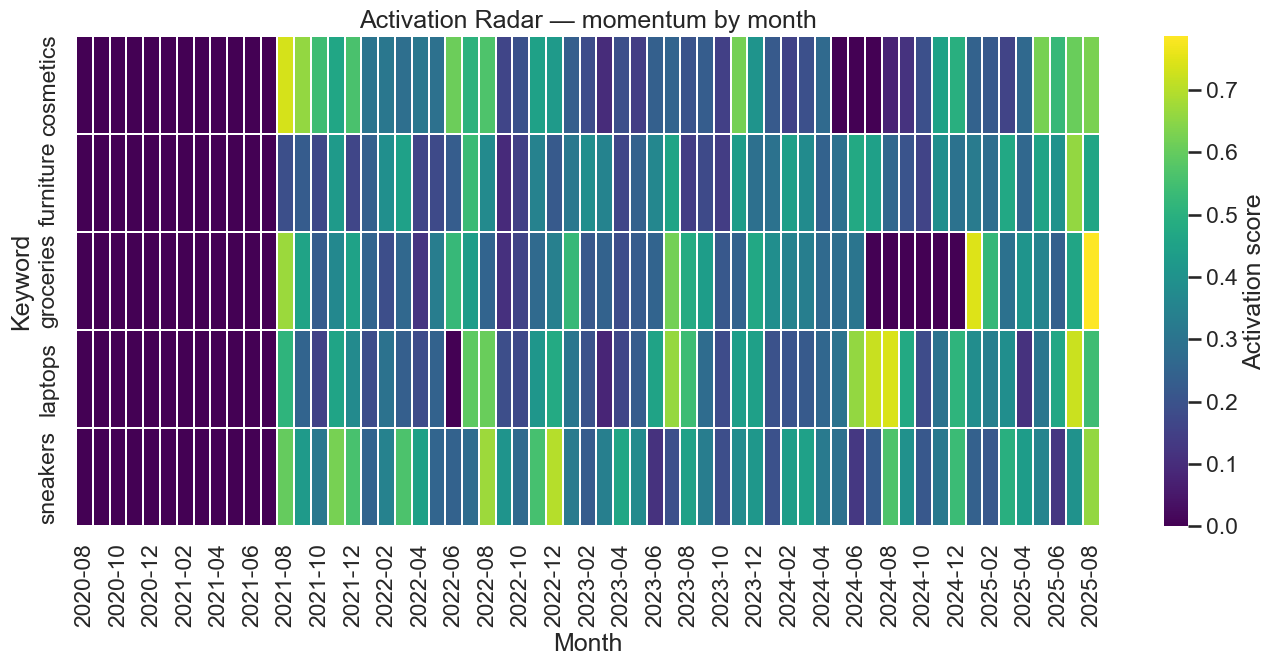

In [4]:
import seaborn as sns
pv = tmp.pivot(index="keyword", columns="month", values="act_score").fillna(0)

plt.figure(figsize=(14, 5 + 0.4*pv.shape[0]))
sns.heatmap(pv, cmap="viridis", linewidths=.3, cbar_kws={"label": "Activation score"})
plt.title("Activation Radar — momentum by month")
plt.xlabel("Month"); plt.ylabel("Keyword")
plt.tight_layout()

out_png = Path("../assets/activation_radar.png")
out_png.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_png, dpi=160)
out_png.as_posix()


In [5]:
from pathlib import Path
import pandas as pd
from math import isnan

excel_path = Path("../reports/sample_activation_radar.xlsx")
excel_path.parent.mkdir(parents=True, exist_ok=True)

# Choose engine/mode based on whether the file exists
if excel_path.exists():
    engine, mode = "openpyxl", "a"   # append with openpyxl
else:
    engine, mode = "xlsxwriter", "w" # create new with xlsxwriter

with pd.ExcelWriter(excel_path, engine=engine, mode=mode, if_sheet_exists="replace") as writer:
    # Write/replace sheets
    tmp_sorted = tmp.sort_values(["keyword","month"])
    tmp_sorted.to_excel(writer, index=False, sheet_name="Activation_Radar")
    top_months.to_excel(writer, index=False, sheet_name="Top_Months")

    # -------- Autosize columns (supports both engines) --------
    def col_widths_from_df(df: pd.DataFrame):
        widths = []
        for col in df.columns:
            header_len = len(str(col)) + 2
            # sample cell length (safe if column is empty)
            series = df[col].astype(str)
            if series.size:
                p90 = int(series.str.len().quantile(0.90)) + 2
            else:
                p90 = 12
            widths.append(max(12, min(40, header_len, p90)))
        return widths

    # Get writer engine
    eng = writer.engine

    # Resize per sheet
    for sheet_name, df_ in [("Activation_Radar", tmp_sorted), ("Top_Months", top_months)]:
        ws = writer.sheets[sheet_name]
        widths = col_widths_from_df(df_)
        if eng == "xlsxwriter":
            # XlsxWriter API
            for j, w in enumerate(widths):
                ws.set_column(j, j, w)
        else:
            # openpyxl API
            from openpyxl.utils import get_column_letter
            for j, w in enumerate(widths, start=1):
                col_letter = get_column_letter(j)
                ws.column_dimensions[col_letter].width = w

excel_path.as_posix()


'../reports/sample_activation_radar.xlsx'

In [6]:
reco = (top_months.sort_values(["keyword","act_score"], ascending=[True, False])
        .groupby("keyword").head(1).copy())
reco["rec"] = ("Prioritize activation in " + reco["month"] +
               " given high momentum (score=" + reco["act_score"].round(2).astype(str) +
               ", YoY=" + reco["avg_yoy"].round(1).astype(str) +
               ", z=" + reco["avg_z"].round(2).astype(str) + ").")
reco[["keyword","rec"]]


,keyword,rec
12,cosmetics,Prioritize activation in 2021-08 given high mo...
120,furniture,Prioritize activation in 2025-07 given high mo...
182,groceries,Prioritize activation in 2025-08 given high mo...
231,laptops,Prioritize activation in 2024-08 given high mo...
272,sneakers,Prioritize activation in 2022-12 given high mo...


../assets/activation_radar.png


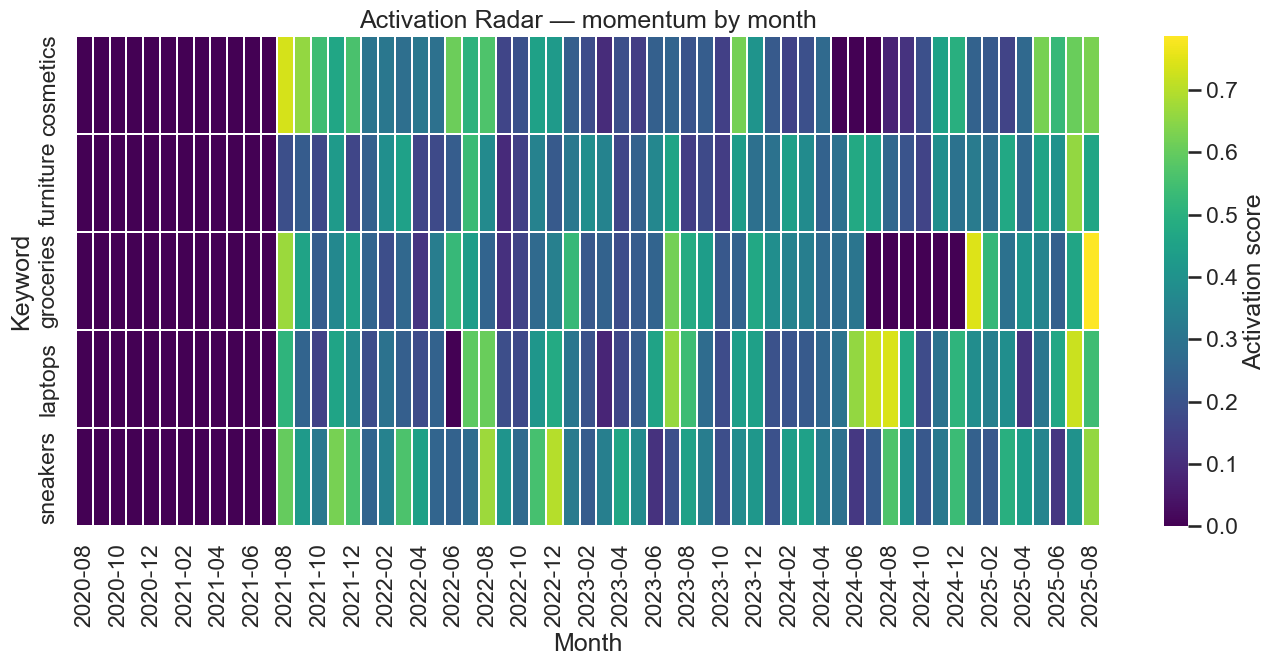

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# pv ya viene de la celda 4; si no existe, vuelve a ejecutar las celdas 1–3
plt.figure(figsize=(14, 5 + 0.4*pv.shape[0]))
sns.heatmap(pv, cmap="viridis", linewidths=.3, cbar_kws={"label": "Activation score"})
plt.title("Activation Radar — momentum by month")
plt.xlabel("Month"); plt.ylabel("Keyword")
plt.tight_layout()

Path("../assets").mkdir(parents=True, exist_ok=True)
out_png = Path("../assets/activation_radar.png")
plt.savefig(out_png, dpi=160)
print(out_png.as_posix())
